# <span style="color:#ff4238;">__DATA 200 FINAL Project__</span>

#### Authors: Brandon Chan, Lucas Duncan, Owen Macgowan, Brayden Van De Wynckel

#### Date: April 2024

![Friends](https://qph.cf2.quoracdn.net/main-qimg-55f2935b1d162eb07783e02013ca66e9-lq)

---
## <span style="color:#42a2d6;">__Summary of Contents__</span>
#### __Our Final project will build on our midterm and cover the following topics:__
1. Background and Purpose
2. Research Question
3. Importing Data
4. Processing Data
5. Inference
6. Prediction Task
7. Regression + Classification

# <span style="color:#f6be00;">__1. Background and Purpose__</span>
The frequency of dialogue By characters, and between characters in a show, as well as the tone of this dialogue (ie exclamatory dialogue) plays a huge role in determining the feel, emotion, and plot itself of a film/tv show. These factors among other things, greatly impact 
not only the story being told, but the perception of it by its viewer, and its perception of quality by its rater.

Within our midterm project we looked at the well known tv show FRIENDS, and we found correlations existed between frequency of dialogue and exclamatory dialogue by certain main characters, and the rating of the episode it occured in, as well as finding a relationship between the viewership size of the episode it occured in.

For our final project, we wanted to build on this idea:

One of us had recently been watching the show, and noticed, the show commonly brought on Celebrities to feature as "non main characters" for an episode or two, and he had wondered, what impact the participation of such background characters interacting with the larger show had on its audience perception.

So, In addition to furthering our look into dialogue and exclamatory dialogue (we consider text in upper case, or containing excalamation marks exclamatory) by the main characters, we also wanted to see, and model whether a relationship exists, between the collective dialogue, and collective exclamatory dialogue of the non-main characters, on the critics and viewers perception of the episode they belong to.

## <span style="color:#f6be00;">__2 General Research Question__</span>
### Does a correlation exist between the frequency of dialogue, and exclamatory dialogue by indidiual main character, as well as collective non-main characters, with the shows viewership numbers and ratings across episodes. 

### Can nothing more then exclamatory dialogue be a an effective predictor for it?, what trends tend to contribute to an episodes success?, and can we guess whether an episode will be better liked by critics or fans using it?






# <span style="color:#ff4238;">__3. Imports__</span>
#### This section imports all of the required components for data importing, data cleaning, visualization, and modeling.

In [359]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import sklearn.metrics as sklm
from sklearn.model_selection import GridSearchCV

In [314]:
dialogue = pd.read_csv(("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-08/friends.csv"))
dialogue.sample(2)

,text,speaker,season,episode,scene,utterance
38254,Oh.,Ross Geller,6,15,5,20
28293,"I don't know, how about the idiot who thought ...",Monica Geller,5,5,5,23


In [315]:
episodes = pd.read_csv(("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-08/friends_info.csv"))
episodes.sample(2)

,season,episode,title,directed_by,written_by,air_date,us_views_millions,imdb_rating
28,2,5,The One with Five Steaks and an Eggplant,Ellen Gittelsohn,Chris Brown,1995-10-19,28.3,8.3
83,4,11,The One with Phoebe's Uterus,David Steinberg,Seth Kurland,1998-01-08,23.7,8.5


In [316]:
# 6 Main Character Names
main_character_names = ["Ross Geller", "Monica Geller", "Phoebe Buffay", "Chandler Bing", "Joey Tribbiani", "Rachel Green"]

#Filters Out Non Dialogue Rows
all_dialogue = dialogue[~dialogue["speaker"].isin(["Scene Directions", "#ALL#", "NA"])]

#Indexs of  MAIN CHARACTER, OTHER CHARACTER, and EXCLAMATORY Dialogue
dialogue_mc_indexs = all_dialogue["speaker"].isin(main_character_names)
dialogue_oc_indexs = ~all_dialogue["speaker"].isin(main_character_names)
dialogue_exclamatory_indexs = all_dialogue["text"].str.contains(r'[A-Z]{2,}') | all_dialogue["text"].str.contains(r'!')

# <span style="color:#42a2d6;">__4. Data Processing__</span>
#### In this section, we use regex, pivoting, filtering, and joining to create a dataframe with both Target Variables (rating, viewership by episode) as well as character and episode specific verbal occurances, both exclamatory and overall.

#### <span style="color:#42a216;"> NOTE: The Following data is implied to be constructed on a per episode basis (although in section 2, per episode and character is temporarally used, it is later pivoted into this form) </span>

### Functions For Later Use:

In [370]:
def sum_size(x):
    return x.str.len().sum()

def normalize_column(x):
    min_value_1 = min(x)
    max_value_1 = max(x)
    normalized_values_1 = (x - min_value_1) / (max_value_1 - min_value_1)
    return normalized_values_1  
    

### Processing 1/4: Episode Total Exclam/Dialogue Occurances (+Total Other Character Exclam/Dialogue)

In [318]:
#Creates A Row For Every Episode
jt_1 = all_dialogue.groupby(["season", "episode"]).agg("first").reset_index().drop(columns=["scene", "utterance", "speaker", "text"])
jt_1.head(2)

,season,episode
0,1,1
1,1,2


In [319]:
#Groups All Dialogue By Episode
gp = all_dialogue.groupby(["season", "episode"])

#Adding Total Words In Episode:
#jt_1 = pd.merge(jt_1, gp["text"].size().reset_index(name="total_words"))

#Adding Total Scenes In Episode:
#jt_1 = pd.merge(jt_1, gp["scene"].nunique().reset_index(name="total_scenes"))

#Finding Total Lines Said In Episode
jt_1 = pd.merge(jt_1, gp["text"].agg(sum_size).reset_index(name="total_lines"))

#Finding Total Speakers In Episode
jt_1 = pd.merge(jt_1, gp["speaker"].nunique().reset_index(name="total_speakers"))

jt_1.head(3)

,season,episode,total_lines,total_speakers
0,1,1,16876,11
1,1,2,12249,14
2,1,3,12070,10


In [320]:

#Grouped All Non-Main Character Dialogue By Episode
gp = all_dialogue[dialogue_oc_indexs].groupby(["season", "episode"])


#Adding Total Scenes By NON-MAIN characters",
#jt_1 = pd.merge(jt_1, gp["scene"].nunique().reset_index(name="oc_scenes"))

# Finding Collective Lines Of Dialogue, By Non-Main Characters
jt_1 = pd.merge(jt_1, gp["text"].size().reset_index(name="oc_lines"))

#Grouped All Non-Main Character Exclamatory Dialogue By Episode
gp = all_dialogue[dialogue_oc_indexs & dialogue_exclamatory_indexs].groupby(["season", "episode"])

# Finding Total Exclamatory Lines By Non Main Characters
jt_1 = pd.merge(jt_1, gp["text"].size().reset_index(name="oc_exclam"))

jt_1.head(3)

,season,episode,total_lines,total_speakers,oc_lines,oc_exclam
0,1,1,16876,11,27,5
1,1,2,12249,14,69,19
2,1,3,12070,10,24,3


### Processing 2/4: Individual Main Character's Exclam/Dialogue:

In [321]:
#Creates A Row, For Every Episode, For Every Main Character
jt_2 = all_dialogue[dialogue_mc_indexs].groupby(["season", "episode", "speaker"]).agg("first").reset_index().drop(columns=["scene", "utterance", "text"])
jt_2.head(3)

,season,episode,speaker
0,1,1,Chandler Bing
1,1,1,Joey Tribbiani
2,1,1,Monica Geller


In [322]:
#Groups All Main Character Dialogue, By Episode, Speaker
gp = all_dialogue[dialogue_mc_indexs].groupby(["season", "episode", "speaker"])

#Finding Total Lines Per Main Character
jt_2 = pd.merge(jt_2, gp["text"].size().reset_index(name="lines"))

#Adding Total Scenes Per Main Character:
#jt_2 = pd.merge(jt_2, gp["scene"].nunique().reset_index(name="scene"))

#Grouped Data (All Main Character Exclamatory Lines, By Episode, Speaker)
gp = all_dialogue[dialogue_mc_indexs & dialogue_exclamatory_indexs].groupby(["season", "episode", "speaker"])

#Adding Total Exclamatory Lines By Main Characters
jt_2 = pd.merge(jt_2, gp["text"].size().reset_index(name="exclam_lines"))


jt_2.head(3)

,season,episode,speaker,lines,exclam_lines
0,1,1,Chandler Bing,39,8
1,1,1,Joey Tribbiani,39,11
2,1,1,Monica Geller,73,20


In [323]:

#Pivoting Table (To Ensure One Row Per Episode)
jt_2 = jt_2.pivot(index=["season", "episode"], columns="speaker", values=["lines", #"scene", 
                                                                          "exclam_lines"]).reset_index(inplace=False)

#Renaming Columns + Reseting Index
jt_2.columns = ['_'.join(map(str, col)).strip() for col in jt_2.columns.values]
jt_2.reset_index(inplace=False)
jt_2.rename(columns={"season_":"season", "episode_":"episode"}, inplace=True)

jt_2.head(2)

,season,episode,lines_Chandler Bing,lines_Joey Tribbiani,lines_Monica Geller,lines_Phoebe Buffay,lines_Rachel Green,lines_Ross Geller,exclam_lines_Chandler Bing,exclam_lines_Joey Tribbiani,exclam_lines_Monica Geller,exclam_lines_Phoebe Buffay,exclam_lines_Rachel Green,exclam_lines_Ross Geller
0,1,1,39.0,39.0,73.0,19.0,48.0,47.0,8.0,11.0,20.0,5.0,15.0,8.0
1,1,2,16.0,8.0,28.0,14.0,38.0,68.0,2.0,1.0,5.0,9.0,8.0,10.0


### Processing 3/4: Episode Review/Viewership Info (Target Variables)

In [324]:
#Taking Existing Episode df and dropping certain attributes
jt_3 = episodes.drop(columns=["title", "directed_by", "written_by", "air_date"])
jt_3.head(3)

,season,episode,us_views_millions,imdb_rating
0,1,1,21.5,8.3
1,1,2,20.2,8.1
2,1,3,19.5,8.2


### Processing 4/4: Joining Tables + Summary

In [343]:
joined_table_final = pd.merge(pd.merge(jt_1, jt_2, on=["season", "episode"]), jt_3, on=["season", "episode"])
joined_table_final = joined_table_final.dropna().sort_values(by=["season", "episode"])
joined_table_final["intercept"] = 1
joined_table_final.head(2)

,season,episode,total_lines,total_speakers,oc_lines,oc_exclam,lines_Chandler Bing,lines_Joey Tribbiani,lines_Monica Geller,lines_Phoebe Buffay,...,lines_Ross Geller,exclam_lines_Chandler Bing,exclam_lines_Joey Tribbiani,exclam_lines_Monica Geller,exclam_lines_Phoebe Buffay,exclam_lines_Rachel Green,exclam_lines_Ross Geller,us_views_millions,imdb_rating,intercept
0,1,1,16876,11,27,5,39.0,39.0,73.0,19.0,...,47.0,8.0,11.0,20.0,5.0,15.0,8.0,21.5,8.3,1
1,1,2,12249,14,69,19,16.0,8.0,28.0,14.0,...,68.0,2.0,1.0,5.0,9.0,8.0,10.0,20.2,8.1,1


# <span style="color:#42a2d6;">__5. Inference Task __</span>
#### ...... SUMMARY TO BE FILLED IN................ LEAVE FOR BRANDON

In [326]:
# I want to verify that use of exclamatory speech really does impact episode IMDb rating 

# Resampling import to use in bootstrapping 
from sklearn.utils import resample

# Combining columns with exclamation
exclam_cols = ['exclam_lines_Chandler Bing','exclam_lines_Joey Tribbiani','exclam_lines_Monica Geller','exclam_lines_Phoebe Buffay','exclam_lines_Rachel Green','exclam_lines_Ross Geller']
exclam = joined_table_final['oc_exclam'] 
for col_name in exclam_cols:
    exclam = exclam + joined_table_final.loc[:,col_name]

# Creates new dataframe with the desired columns (rating and # of exclamations)
df_exclam = pd.DataFrame({"Exclamations":exclam, "Rating":joined_table_final['imdb_rating']})
mean_exclam = np.round(np.mean(df_exclam), 0)
df_exclam.fillna({'Exclamations':mean_exclam}, inplace=True)

# Defines two populations: IMDb ratings with high exclamation use and ratings with low exclamation use 
df_exclam 
mean_exclamation = np.mean(df_exclam['Exclamations'])
pop1 = df_exclam[df_exclam['Exclamations']>mean_exclamation]['Rating']
pop2 = df_exclam[df_exclam['Exclamations']<=mean_exclamation]['Rating']

# Define number of bootstrap resamples
n_resamples = 1000
mean_diffs = np.zeros(n_resamples)

# Bootstrapping procedure (add difference in each resampled mean to the list)
for i in range(n_resamples):
    s1 = resample(pop1, replace=True)
    s2 = resample(pop2, replace=True)
    mean_diffs[i] = np.mean(s1)-np.mean(s2) 
    
# Confidence interval 
ci_95 = np.percentile(mean_diffs, [2.5, 97.5]) 

# Mean Difference 
mean_difference = round(np.mean(mean_diffs),2)

print(f'On average, episodes with more exclamation have about {mean_difference*100}% higher imdb ratings.')
print(f'The mean difference between ratings is on a 95% confidence interval of being in the range({round(ci_95[0],2)*100}%, {round(ci_95[1],2)*100}%)')


On average, episodes with more exclamation have about 18.0% higher imdb ratings.
The mean difference between ratings is on a 95% confidence interval of being in the range(8.0%, 28.000000000000004%)


It seems that the hypothesis was correct. Episodes with more exclamatory speech tend to have **13%** higher ratings on average! This clearly demonstrates that emphatic speech significantly impacts episode IMDb rating.    

# <span style="color:#42a2d6;">__6. Prediction Task + Cross Validation__</span>

#### Within This Section, through cross validating to find an ideal alpha, and a ridge Regression Model we create 2 models, one predicting a normalized "imdb_rating" (rate), and the other a normalized "us_views_millions" (view): whose accuracy, and coefficient weight placed on certain features will give us a better understanding of our ability to use exclamtory speech to predict these targets, as well as key attributes/features key to maximizing/minimizing them. 

#### <span style="color:#42a216;">INTERESTING NOTE: we have left the numbered episode, season features within the model, becasue we were curious to see whether how far into a season (episode), or overall show (season) an episode was had any impact on its rating and views.  </span>

In [369]:

# Separate features and target variables, and normalize
x_cols = joined_table_final.drop(["us_views_millions", "imdb_rating"], axis=1)

normalized_y_views = normalize_column(pd.Series(joined_table_final['us_views_millions']))


normalized_y_rating = normalize_column(pd.Series(joined_table_final['imdb_rating']))
# normalized_y_rating = normalized_y_rating/normalized_y_rating.mean()

# Split data used for VIEW, RATING prediction
X_train_view, X_test_view, y_train_view, y_test_view = train_test_split(x_cols, normalized_y_views, test_size=0.10) 
X_train_rate, X_test_rate, y_train_rate, y_test_rate = train_test_split(x_cols, normalized_y_rating, test_size=0.10)

# Scale data for VIEW, RATING prediction
scaler = StandardScaler()
X_train_view_scaled = scaler.fit_transform(X_train_view)
X_test_view_scaled = scaler.transform(X_test_view)
X_train_rate_scaled = scaler.fit_transform(X_train_rate)
X_test_rate_scaled = scaler.transform(X_test_rate)


In [361]:


#Find Ideal Alpha For VIEW, RATING Prediction
cv = RepeatedKFold(n_splits=10, n_repeats=3) 
model_ridge_cv_1 = RidgeCV(alphas=np.arange(0.01, 1000, 1), cv=cv, scoring='neg_mean_squared_error') 
model_ridge_cv_1.fit(X_train_view_scaled, y_train_view)
view_ideal_alpha = model_ridge_cv_1.alpha_

model_ridge_cv_2 = RidgeCV(alphas=np.arange(0.01, 1000, 1), cv=cv, scoring='neg_mean_squared_error') 
model_ridge_cv_2.fit(X_train_rate_scaled, y_train_rate)
rate_ideal_alpha = model_ridge_cv_2.alpha_


print("Ideal alpha for VIEW prediction:", view_ideal_alpha)
print("Ideal alpha for RATE prediction:", rate_ideal_alpha)

Ideal alpha for VIEW prediction: 38.01
Ideal alpha for RATE prediction: 335.01


MSE VIEW MODEL (TRAIN): 0.012640997050302877 (fraction of mean 0.05008422216705551)
MSE RATE MODEL (TRAIN): 0.02425835544110805 (fraction of mean 0.04823325478772897)


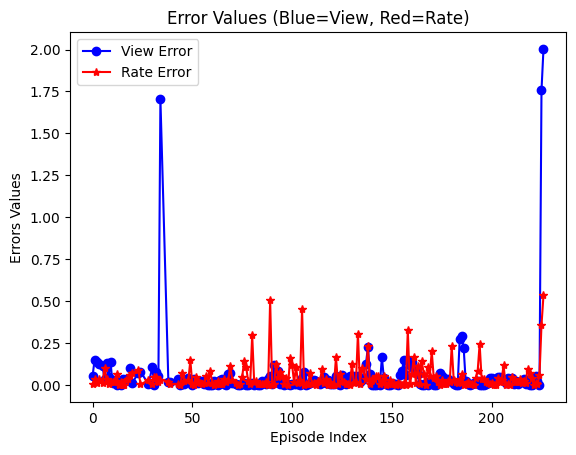

In [371]:

#Training Model With Optimal Alpha, for VIEW, RATE
model_for_view = Ridge(alpha=view_ideal_alpha)
model_for_view = model_for_view.fit(X_train_view_scaled, y_train_view)
model_for_rate = Ridge(alpha=rate_ideal_alpha)
model_for_rate = model_for_rate.fit(X_train_rate_scaled, y_train_rate)

#Printing Error (TRAIN)
e1 = sklm.mean_squared_error(y_train_view, model_for_view.predict(X_train_view_scaled))
print(f'MSE VIEW MODEL (TRAIN): {e1} (fraction of mean {e1/normalized_y_views.mean()})')
e2 = sklm.mean_squared_error(y_train_rate, model_for_rate.predict(X_train_rate_scaled))
print(f'MSE RATE MODEL (TRAIN): {e2} (fraction of mean {e2/normalized_y_rating.mean()})')

#Plotting Error: (ON ALL - SQUARED ERROR)
view_error = pd.Series(((normalized_y_views - model_for_view.predict(scaler.fit_transform(x_cols)))**2)/normalized_y_views.mean())
rate_error = pd.Series(((normalized_y_rating - model_for_rate.predict(scaler.fit_transform(x_cols)))**2)/normalized_y_rating.mean())

view_error.plot( color='blue' , label='View Error', marker="o")
rate_error.plot( color='red', label='Rate Error', marker="*")
plt.xlabel('Episode Index')
plt.ylabel('Errors Values')
plt.title('Error Values (Blue=View, Red=Rate)')
plt.legend()
plt.show()

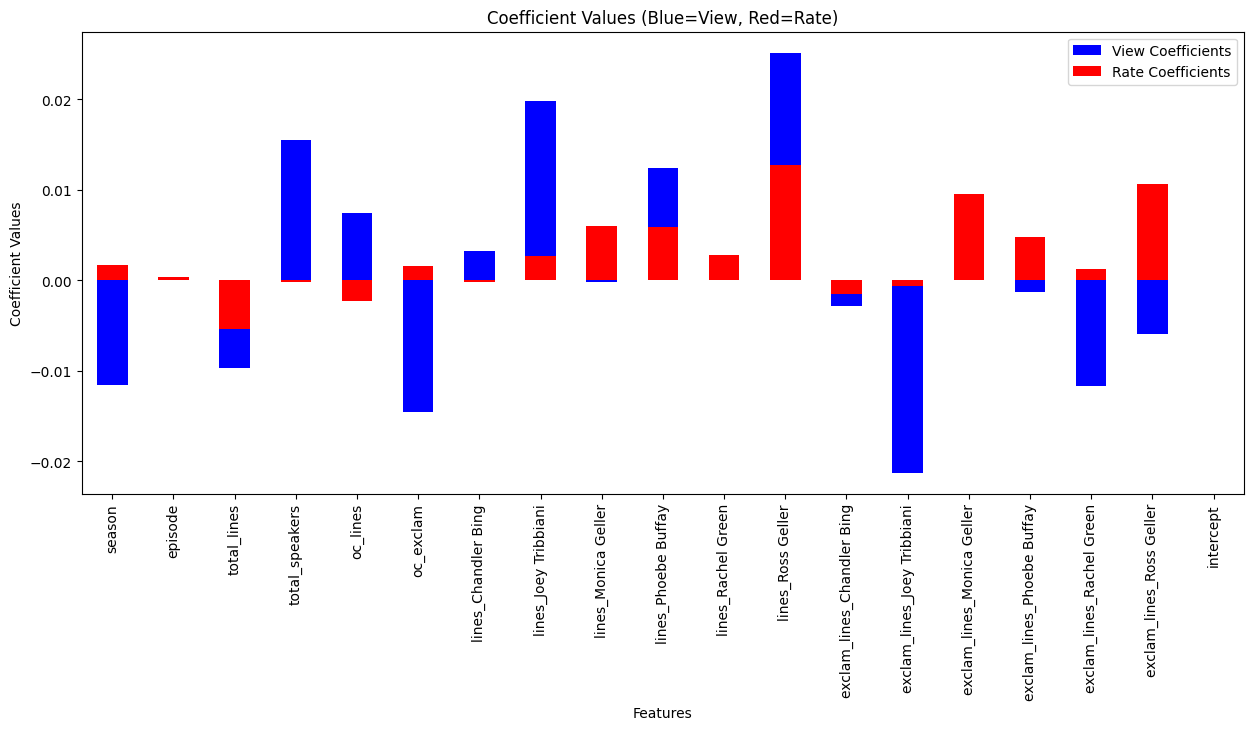

In [372]:
#Saving Coefficients:
view_coefficients = pd.Series(model_for_view.coef_, index=X_train_rate.columns)
rate_coefficients = pd.Series(model_for_rate.coef_, index=X_train_rate.columns)

#Ploting The Different Weights, Of Each Feature, For RATE, and VIEW
plt.figure(figsize=(15, 6))
view_coefficients.plot(kind='bar', color='blue' , label='View Coefficients')
rate_coefficients.plot(kind='bar', color='red', label='Rate Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Values')
plt.title('Coefficient Values (Blue=View, Red=Rate)')
plt.legend()
plt.show()

##### Test

# <span style="color:#42a2d6;">__7. Regression and Classification__</span>
#### ...........SUMMARY TO BE ADDED........

In [331]:
#LUCAS TINKERING::::



0.0003309545190993332
0.1619506302877754


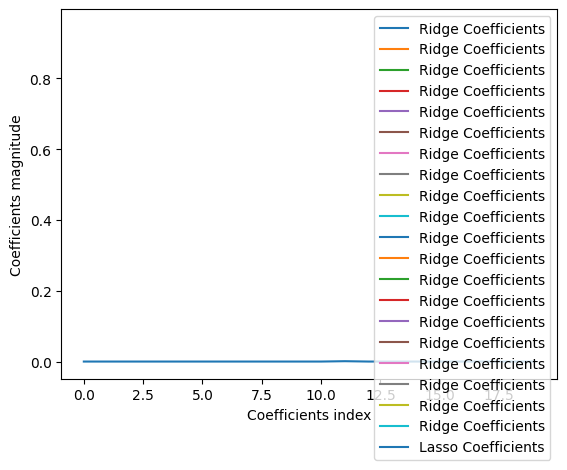

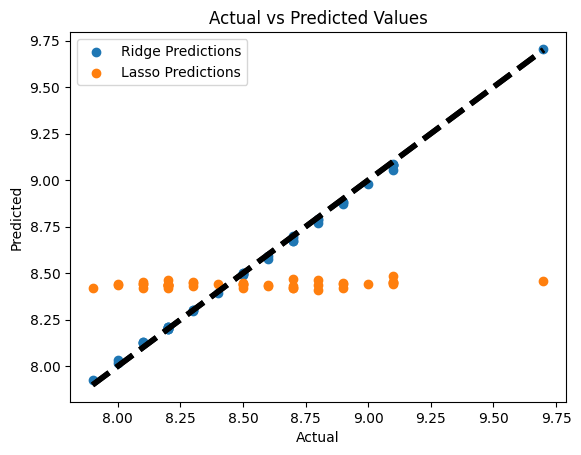

In [332]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming X_train, X_test, y_train, y_test are your training and testing data
# Split the data into training and testing sets
X = joined_table_final.loc[:, joined_table_final.columns != 'speaker'].reset_index(drop=True)
y = joined_table_final[['imdb_rating']].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Regression
ridge_reg = Ridge(alpha=1.0)  # Alpha is the regularization parameter
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print(ridge_mse)

# Lasso Regression
lasso_reg = Lasso(alpha=1.0)  # Alpha is the regularization parameter
lasso_reg.fit(X_train, y_train)
lasso_pred = lasso_reg.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print(lasso_mse)

ridge_coefficients = ridge_reg.coef_
lasso_coefficients = lasso_reg.coef_

# Plot Ridge coefficients
plt.plot(range(len(ridge_coefficients)), ridge_coefficients, label='Ridge Coefficients')

# Plot Lasso coefficients
plt.plot(range(len(lasso_coefficients)), lasso_coefficients, label='Lasso Coefficients')

plt.xlabel('Coefficients index')
plt.ylabel('Coefficients magnitude')
plt.legend()
plt.show()

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# Actual vs Predicted plot for Ridge
plt.scatter(y_test, ridge_pred, label='Ridge Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# Actual vs Predicted plot for Lasso
plt.scatter(y_test, lasso_pred, label='Lasso Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [333]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
joined_table_final_c = joined_table_final.copy()
joined_table_final_c['high_rating'] = np.where(joined_table_final_c['imdb_rating'] > 8.0, 1, 0)

# Define the features and the target.
X = joined_table_final_c.loc[:, joined_table_final.columns != 'speaker']
X = X.drop(['imdb_rating', 'high_rating'], axis=1)  # Drop the original 'imdb_rating' and the new binary target column from the features.
y = joined_table_final['high_rating']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Logistic Regression classifier.
log_reg = LogisticRegression()

# Fit the classifier to the training data.
log_reg.fit(X_train, y_train)

# Predict on the testing set.
y_pred = log_reg.predict(X_test)

# Evaluate the classifier.
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

# Assume log_reg is your trained Logistic Regression model, and X_test and y_test are your test dataset.

# Get predicted probabilities
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Display the classification report
print(classification_report(y_test, log_reg.predict(X_test)))

# Compute and plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming log_reg is your trained Logistic Regression model
# and y_test, y_pred are your test labels and predictions respectively

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Adding the text labels
classes = ['Class 0', 'Class 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Labeling the plot
thresh = cm.max() / 2. # for text color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")  # text color

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

IndexError: Boolean index has wrong length: 20 instead of 21

# <span style="color:#42a2d6;">__6. Conclusions__</span>

..... TO BE ADDED ......